In [ ]:
"""
Predicting picture label in CIFAR dataset. 

The CIFAR-10 dataset consists of 60000 32x32 colour images
in 10 classes ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
with 6000 images per class.

Convolutional neural network is used for learning. 
Data augmented by normalization, flips and crops.
"""

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import  pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
mean_val = [0.485, 0.456, 0.406]
stdev = [0.229, 0.224, 0.225]

augmentation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_val, stdev),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),  
    # transforms.RandomRotation(360),
    transforms.RandomCrop(30)            
])



"""
Denormalization. Used for visual check of transformations
 """
unnorm_toPIL = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],
                                  std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                  std = [ 1., 1., 1. ]),
                        
    transforms.ToPILImage()
])

transform = transforms.Compose([ 
    transforms.FiveCrop(32),
    transforms.Lambda(lambda crops: torch.stack([augmentation(crop) for crop in crops]))
])

In [3]:
class UnNormalizer(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            None
            Shows initial image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        plt.imshow(tensor.permute(1, 2, 0))
        plt.pause(0.01)


unnormer = UnNormalizer(mean_val, stdev)

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def change_shape(batch):
  """Changes shape of augmented batch from [256, 5, 3, 30, 30]
  to [1280, 3, 30, 30] and adds missing labels to target"""
  images, labels = batch

  bs, n_crops, ch, h, w = images.shape

  new_images = images.view(-1, ch, h, w)

  new_labels = torch.zeros(bs * n_crops)

  for i in range(0, bs * n_crops, n_crops):
    new_labels[i:i+n_crops] = labels[i // n_crops]
  new_labels = new_labels.long()

  return new_images, new_labels

In [6]:
images, labels = change_shape(next(iter(trainloader)))
images.shape, labels.shape

(torch.Size([1280, 3, 30, 30]), torch.Size([1280]))

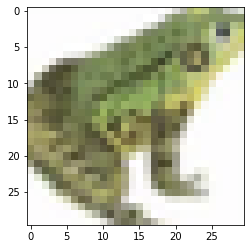

In [7]:
plt.imshow(unnorm_toPIL(images[0]))

frog


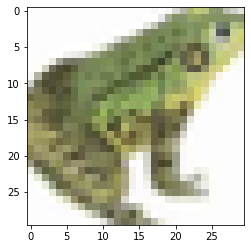

frog


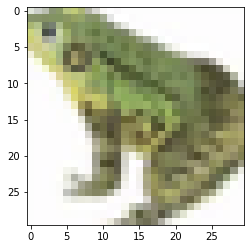

frog


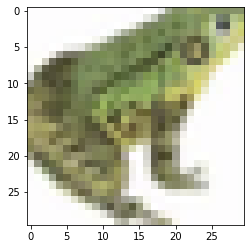

frog


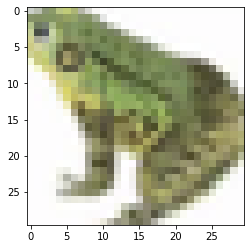

frog


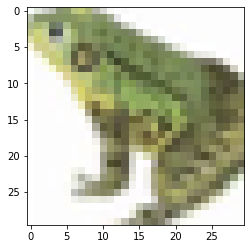

car


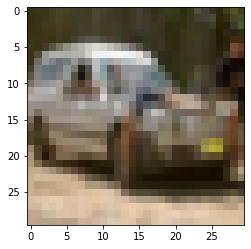

car


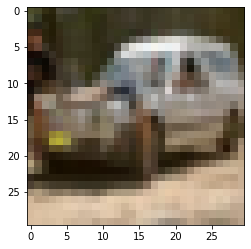

car


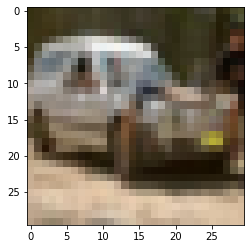

car


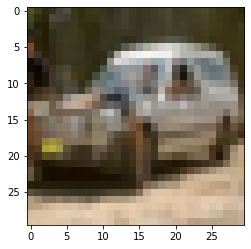

car


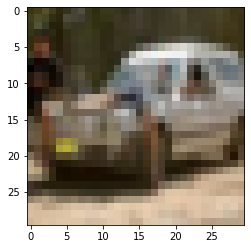

In [8]:
for i in range(10):
  print(classes[labels[i]])
  unnormer(images[i])

In [9]:
len(trainloader), len(testloader)

(196, 196)

In [10]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.fc1 = nn.Linear(5 * 5 * 128, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 5*5*128)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [11]:
net = ConvNet()
net.to('cuda')
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

30th batch processed
60th batch processed
90th batch processed
120th batch processed
150th batch processed
180th batch processed
1 epochs completed, loss value: 1.1572160720825195
30th batch processed
60th batch processed
90th batch processed
120th batch processed
150th batch processed
180th batch processed
2 epochs completed, loss value: 1.2098362445831299
30th batch processed
60th batch processed
90th batch processed
120th batch processed
150th batch processed
180th batch processed
3 epochs completed, loss value: 0.8919486403465271
30th batch processed
60th batch processed
90th batch processed
120th batch processed
150th batch processed
180th batch processed
4 epochs completed, loss value: 0.8327063918113708
30th batch processed
60th batch processed
90th batch processed
120th batch processed
150th batch processed
180th batch processed
5 epochs completed, loss value: 1.1649924516677856
30th batch processed
60th batch processed
90th batch processed
120th batch processed
150th batch pro

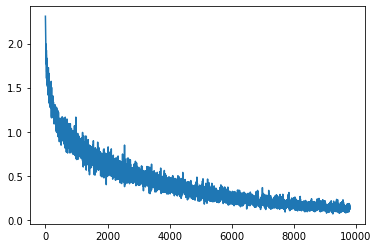

In [12]:
loss_list = []
best_loss = 100
best_net = ConvNet()

for epoch in range(50):
  for i, batch in enumerate(trainloader):
    
    X_batch, y_batch = change_shape(batch)
    
    X_batch = X_batch.to('cuda')
    y_batch = y_batch.to('cuda')

    optimizer.zero_grad()

    y_pred = net(X_batch)
    loss = loss_fn(y_pred, y_batch)
    loss_list.append(loss)

    if loss.item() < best_loss:
      best_loss = loss.item()
      best_net = net

    loss.backward()
    optimizer.step()
    if (i + 1) % 30 == 0 and i != 0:
      print(f'{i+1}th batch processed')
  print(f'{epoch+1} epochs completed, loss value: {loss.item()}')

plt.plot(loss_list)

In [13]:
label_results = [[0, 0] for _ in range(10)]

with torch.no_grad():
  for data in testloader:
    images, labels = change_shape(data)
    images = images.to('cuda')

    y_pred = net(images)

    for image, label, pred in zip(images, labels, y_pred):
      if pred.argmax() == label.item():
        label_results[label][1] += 1
      label_results[label][0] += 1

In [14]:
for i in range(10):
  print(f' class: {classes[i]} correct answers: {round(label_results[i][1] / label_results[i][0] * 100, 2)} %')

sum_res = np.sum(label_results, axis=0)
print(f'total correct answers: {round(sum_res[1] / sum_res[0] * 100, 2)} %')

 class: plane correct answers: 94.54 %
 class: car correct answers: 99.13 %
 class: bird correct answers: 97.56 %
 class: cat correct answers: 92.91 %
 class: deer correct answers: 94.07 %
 class: dog correct answers: 93.68 %
 class: frog correct answers: 94.28 %
 class: horse correct answers: 97.5 %
 class: ship correct answers: 98.45 %
 class: truck correct answers: 96.32 %
total correct answers: 95.85 %
